# Tải Dữ liệu

In [5]:
import kagglehub

# Download latest version
data_dir = kagglehub.dataset_download("andrewmvd/dog-and-cat-detection")

print("Path to dataset files:", data_dir)


Path to dataset files: /home/s24gb-1/.cache/kagglehub/datasets/andrewmvd/dog-and-cat-detection/versions/1


# Import Các Thư Viện Cần Thiết

In [6]:
# %pip install torchmetrics
# %pip install pycocotools


In [7]:
import os
import random
import xml.etree.ElementTree as ET

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tqdm.notebook as tqdm
from PIL import Image
from torch.utils.data import DataLoader, Dataset, Subset
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision import models, transforms
from torchvision.models.resnet import ResNet50_Weights

# Set the random seed for reproducibility.
seed = 123
torch.manual_seed(seed)


# Định Nghĩa Class Dataset

In [8]:
class MyDataset(Dataset):
    def __init__(self, annotations_dir, image_dir, transform=None):
        self.annotations_dir = annotations_dir
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = self.filter_images_with_multiple_objects()

    def filter_images_with_multiple_objects(self):
        valid_image_files = []
        for f in os.listdir(self.image_dir):
            if os.path.isfile(os.path.join(self.image_dir, f)):
                img_name = f
                annotation_name = os.path.splitext(img_name)[0] + ".xml"
                annotation_path = os.path.join(self.annotations_dir, annotation_name)

                if self.count_objects_in_annotation(annotation_path) == 1:
                    valid_image_files.append(img_name)
        return valid_image_files

    def count_objects_in_annotation(self, annotation_path):
        try:
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            count = 0
            for obj in root.findall("object"):
                count += 1
            return count
        except FileNotFoundError:
            return 0

    def parse_annotation(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        # Get image size for normalization
        image_width = int(root.find("size/width").text)
        image_height = int(root.find("size/height").text)

        label = None
        bbox = None
        for obj in root.findall("object"):
            name = obj.find("name").text
            if label is None:  # Take the first label
                label = name
                # Get bounding box coordinates
                xmin = int(obj.find("bndbox/xmin").text)
                ymin = int(obj.find("bndbox/ymin").text)
                xmax = int(obj.find("bndbox/xmax").text)
                ymax = int(obj.find("bndbox/ymax").text)

                # Normalize bbox coordinates to [0, 1]
                bbox = [
                    xmin / image_width,
                    ymin / image_height,
                    xmax / image_width,
                    ymax / image_height,
                ]

        # Convert label to numerical representation (0 for cat, 1 for dog)
        label_num = 0 if label == "cat" else 1 if label == "dog" else -1

        return label_num, torch.tensor(bbox, dtype=torch.float32)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img1_file = self.image_files[idx]
        img1_path = os.path.join(self.image_dir, img1_file)

        annotation_name = os.path.splitext(img1_file)[0] + ".xml"
        img1_annotations = self.parse_annotation(
            os.path.join(self.annotations_dir, annotation_name)
        )

        if idx == len(self.image_files) - 1:
            idx2 = 0
        else:
            idx2 = idx + 1
        img2_file = self.image_files[idx2]
        img2_path = os.path.join(self.image_dir, img2_file)

        annotation_name = os.path.splitext(img2_file)[0] + ".xml"
        img2_annotations = self.parse_annotation(
            os.path.join(self.annotations_dir, annotation_name)
        )

        img1 = Image.open(img1_path).convert("RGB")
        img2 = Image.open(img2_path).convert("RGB")

        # Horizontal merge
        merged_image = Image.new(
            "RGB", (img1.width + img2.width, max(img1.height, img2.height))
        )
        merged_image.paste(img1, (0, 0))
        merged_image.paste(img2, (img1.width, 0))
        merged_w = img1.width + img2.width
        merged_h = max(img1.height, img2.height)

        merged_annotations = []

        # Adjust bbox coordinates for objects from img1 AND normalize
        new_bbox1 = [
            img1_annotations[1][0] * img1.width / merged_w,  # Normalize xmin
            img1_annotations[1][1] * img1.height / merged_h,  # Normalize ymin
            img1_annotations[1][2] * img1.width / merged_w,  # Normalize xmax
            img1_annotations[1][3] * img1.height / merged_h,  # Normalize ymax
        ]
        merged_annotations.append({"bbox": new_bbox1, "label": img1_annotations[0]})

        # Adjust bbox coordinates for objects from img2 AND normalize
        new_bbox2 = [
            (img2_annotations[1][0] * img2.width + img1.width)
            / merged_w,  # Normalize xmin
            img2_annotations[1][1] * img2.height / merged_h,  # Normalize ymin
            (img2_annotations[1][2] * img2.width + img1.width)
            / merged_w,  # Normalize xmax
            img2_annotations[1][3] * img2.height / merged_h,  # Normalize ymax
        ]

        merged_annotations.append({"bbox": new_bbox2, "label": img2_annotations[0]})

        # Convert merged image to tensor
        if self.transform:
            merged_image = self.transform(merged_image)
        else:
            merged_image = transforms.ToTensor()(merged_image)

        # Convert annotations to 1D tensors, with shape (4,) for bbox and (1,) for label
        annotations = torch.zeros((len(merged_annotations), 5))
        for i, ann in enumerate(merged_annotations):
            annotations[i] = torch.cat(
                (torch.tensor(ann["bbox"]), torch.tensor([ann["label"]]))
            )

        return merged_image, annotations


# Định nghĩa mô hình

In [9]:
class SimpleYOLO(nn.Module):
    def __init__(self, num_classes):
        super(SimpleYOLO, self).__init__()
        self.backbone = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.num_classes = num_classes

        # Remove the final classification layer of ResNet
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])

        # Add the YOLO head
        self.fcs = nn.Linear(
            2048, 2 * 2 * (4 + self.num_classes)
        )  # 2 is for the number of grid cell

    def forward(self, x):
        # x shape: (batch_size, C, H, W)
        features = self.backbone(x)
        features = F.adaptive_avg_pool2d(
            features, (1, 1)
        )  # shape: (batch_size, 2048, 1, 1)
        features = features.view(features.size(0), -1)  # shape: (batch_size, 2048)
        features = self.fcs(features)

        return features


# Định nghĩa các hàm cần thiết

In [10]:
def calculate_loss(output, targets, device, num_classes):
    mse_loss = nn.MSELoss()
    ce_loss = nn.CrossEntropyLoss()

    batch_size = output.shape[0]
    total_loss = 0

    for i in range(batch_size):  # Iterate through each image in the batch
        grid_have_object = torch.zeros((batch_size, 2, 2), device=device)

        for j in range(len(targets[i])):  # Iterate through objects in the image
            # Determine which grid cell the object's center falls into
            # Assuming bbox coordinates are normalized to [0, 1]
            bbox_center_x = (targets[i][j][0] + targets[i][j][2]) / 2
            bbox_center_y = (targets[i][j][1] + targets[i][j][3]) / 2

            grid_x = int(
                bbox_center_x * 2
            )  # Multiply by number of grid cells (2 in this case)
            grid_y = int(bbox_center_y * 2)

            grid_have_object[i, grid_y, grid_x] = 1

            # 1. Classification Loss for the responsible grid cell
            # Convert label to one-hot encoding only for this example
            label_one_hot = torch.zeros(num_classes, device=device)
            label_one_hot[int(targets[i][j][4])] = 1

            # Classification loss (using CrossEntropyLoss)
            classification_loss = ce_loss(output[i, grid_y, grid_x, 4:], label_one_hot)

            # 2. Regression Loss for the responsible grid cell
            bbox_target = targets[i][j][:4].to(device)
            regression_loss = mse_loss(output[i, grid_y, grid_x, :4], bbox_target)

            # import pdb; pdb.set_trace()

            total_loss += classification_loss + regression_loss

        # 3. No Object Loss (for other grid cells)
        no_obj_loss = 0
        for other_grid_y in range(2):
            for other_grid_x in range(2):
                if grid_have_object[i, other_grid_y, other_grid_x] == 0:
                    # MSE loss for predicting no object (all zeros)
                    no_obj_loss += mse_loss(
                        output[i, other_grid_y, other_grid_x, :4],
                        torch.zeros(4, device=device),
                    )

        total_loss += no_obj_loss

    return total_loss / batch_size  # Average loss over the batch


In [11]:
def calculate_iou(box1, box2):
    # Calculate intersection coordinates
    x_a = max(box1[0], box2[0])
    y_a = max(box1[1], box2[1])
    x_b = min(box1[2], box2[2])
    y_b = min(box1[3], box2[3])

    # Compute the area of intersection
    inter_area = max(0, x_b - x_a) * max(0, y_b - y_a)

    # Compute the area of both the prediction and ground-truth
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Compute the IoU
    iou = inter_area / float(box1_area + box2_area - inter_area)

    return iou


In [12]:
def evaluate_model(model, data_loader, device, num_classes):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, targets in tqdm.tqdm(data_loader, desc="Validation", leave=False):
            images = images.to(device, non_blocking=True)

            output = model(images)

            # Reshape output to (batch_size, grid_y, grid_x, 4 + num_classes)
            output = output.view(images.shape[0], 2, 2, 4 + num_classes)

            total_loss = calculate_loss(output, targets, device, num_classes)
            running_loss += total_loss.item()

            # Convert predictions and targets to the format required by MeanAveragePrecision
            for batch_idx in range(images.shape[0]):
                preds = []
                targs = []

                # Process ground truth targets
                for target in targets[batch_idx]:
                    targs.append(
                        {
                            "boxes": target[:4].unsqueeze(0),
                            "labels": target[4]
                            .unsqueeze(0)
                            .long(),  # Convert label to Long
                        }
                    )

                # Match predictions to ground truth targets based on highest IoU
                # Iterate through targets first to find the best matching prediction for each target
                for target_idx, target in enumerate(targets[batch_idx]):
                    best_iou = -1
                    best_pred_idx = -1

                    for grid_y in range(2):
                        for grid_x in range(2):
                            # Extract predicted bounding box
                            bbox_pred = output[batch_idx, grid_y, grid_x, :4]

                            # Skip predictions where bbox is approximately [0, 0, 0, 0]
                            if torch.all(torch.round(bbox_pred, decimals=2) == 0):
                                continue

                            # Calculate IoU with the current target
                            iou = calculate_iou(bbox_pred, target[:4])

                            # If this prediction has higher IoU than current best, update
                            if iou > best_iou:
                                best_iou = iou
                                best_pred_idx = (grid_y, grid_x)

                    # If a best match is found for this target, add the prediction
                    if best_pred_idx != -1:
                        grid_y, grid_x = best_pred_idx
                        bbox_pred = output[batch_idx, grid_y, grid_x, :4]
                        class_probs = torch.softmax(
                            output[batch_idx, grid_y, grid_x, 4:], dim=0
                        )
                        class_pred = class_probs.argmax().item()
                        confidence = class_probs[class_pred].item()

                        preds.append(
                            {
                                "boxes": bbox_pred.unsqueeze(0),
                                "scores": torch.tensor([confidence], device=device),
                                "labels": torch.tensor([class_pred], device=device),
                            }
                        )

                # Add current batch predictions and targets to the overall lists
                if preds:  # Only add to all_preds if there are any valid predictions
                    all_preds.append(
                        {
                            k: v.to(device) if isinstance(v, torch.Tensor) else v
                            for k, v in preds[0].items()
                        }
                    )

                if targs:
                    all_targets.append(
                        {
                            k: v.to(device) if isinstance(v, torch.Tensor) else v
                            for k, v in targs[0].items()
                        }
                    )

    val_loss = running_loss / len(data_loader)

    # Calculate mAP
    metric = MeanAveragePrecision()
    metric.update(all_preds, all_targets)
    mAP_dict = metric.compute()

    return val_loss, mAP_dict["map"]


In [13]:
def train_model(
    model, train_loader, val_loader, optimizer, num_epochs, device, num_classes
):
    best_val_map = 0.0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in tqdm.tqdm(range(num_epochs), desc="Epochs"):
        model.train()
        running_loss = 0.0

        for images, targets in tqdm.tqdm(train_loader, desc="Batches", leave=False):
            batch_size = images.shape[0]
            images = images.to(device, non_blocking=True)

            optimizer.zero_grad()
            output = model(images)

            output = output.view(batch_size, 2, 2, 4 + num_classes)
            total_loss = calculate_loss(output, targets, device, num_classes)

            total_loss.backward()
            optimizer.step()
            running_loss += total_loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        # Validation
        val_loss, val_map = evaluate_model(model, val_loader, device, num_classes)
        val_losses.append(val_loss)
        val_accuracies.append(val_map)

        print(
            f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation mAP: {val_map:.4f}"
        )

        # Save the best model
        if val_map > best_val_map:
            best_val_map = val_map
            torch.save(model.state_dict(), "best_model.pth")

    return train_losses, val_losses, train_accuracies, val_accuracies


# Chuẩn Bị Dữ Liệu

In [16]:
# Define paths
annotations_dir = os.path.join(data_dir, "annotations")
image_dir = os.path.join(data_dir, "images")

# Define transformations
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# First create two base datasets with different transforms
base_dataset = MyDataset(annotations_dir, image_dir, transform=transform)

# Get the total dataset size
dataset_size = len(base_dataset)

# Calculate train and validation sizes
val_size = int(0.2 * dataset_size)
train_size = dataset_size - val_size

# Generate indices
indices = np.arange(dataset_size)
np.random.seed(42)  # Ensure reproducibility
np.random.shuffle(indices)

# Split indices for train and validation sets
train_indices, val_indices = indices[:train_size], indices[train_size:]
# train_indices, val_indices = indices[:1], indices[:1]

# Create Subsets using the appropriate base dataset
train_dataset = Subset(base_dataset, train_indices)
val_dataset = Subset(base_dataset, val_indices)

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    pin_memory=True,
    num_workers=4,
    persistent_workers=True,
    drop_last=True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False,
    pin_memory=True,
    num_workers=4,
    persistent_workers=True,
    drop_last=False,
)

# Initialize model, criterion, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 2  # Assuming two classes: dog and cat
class_to_idx = {"dog": 0, "cat": 1}


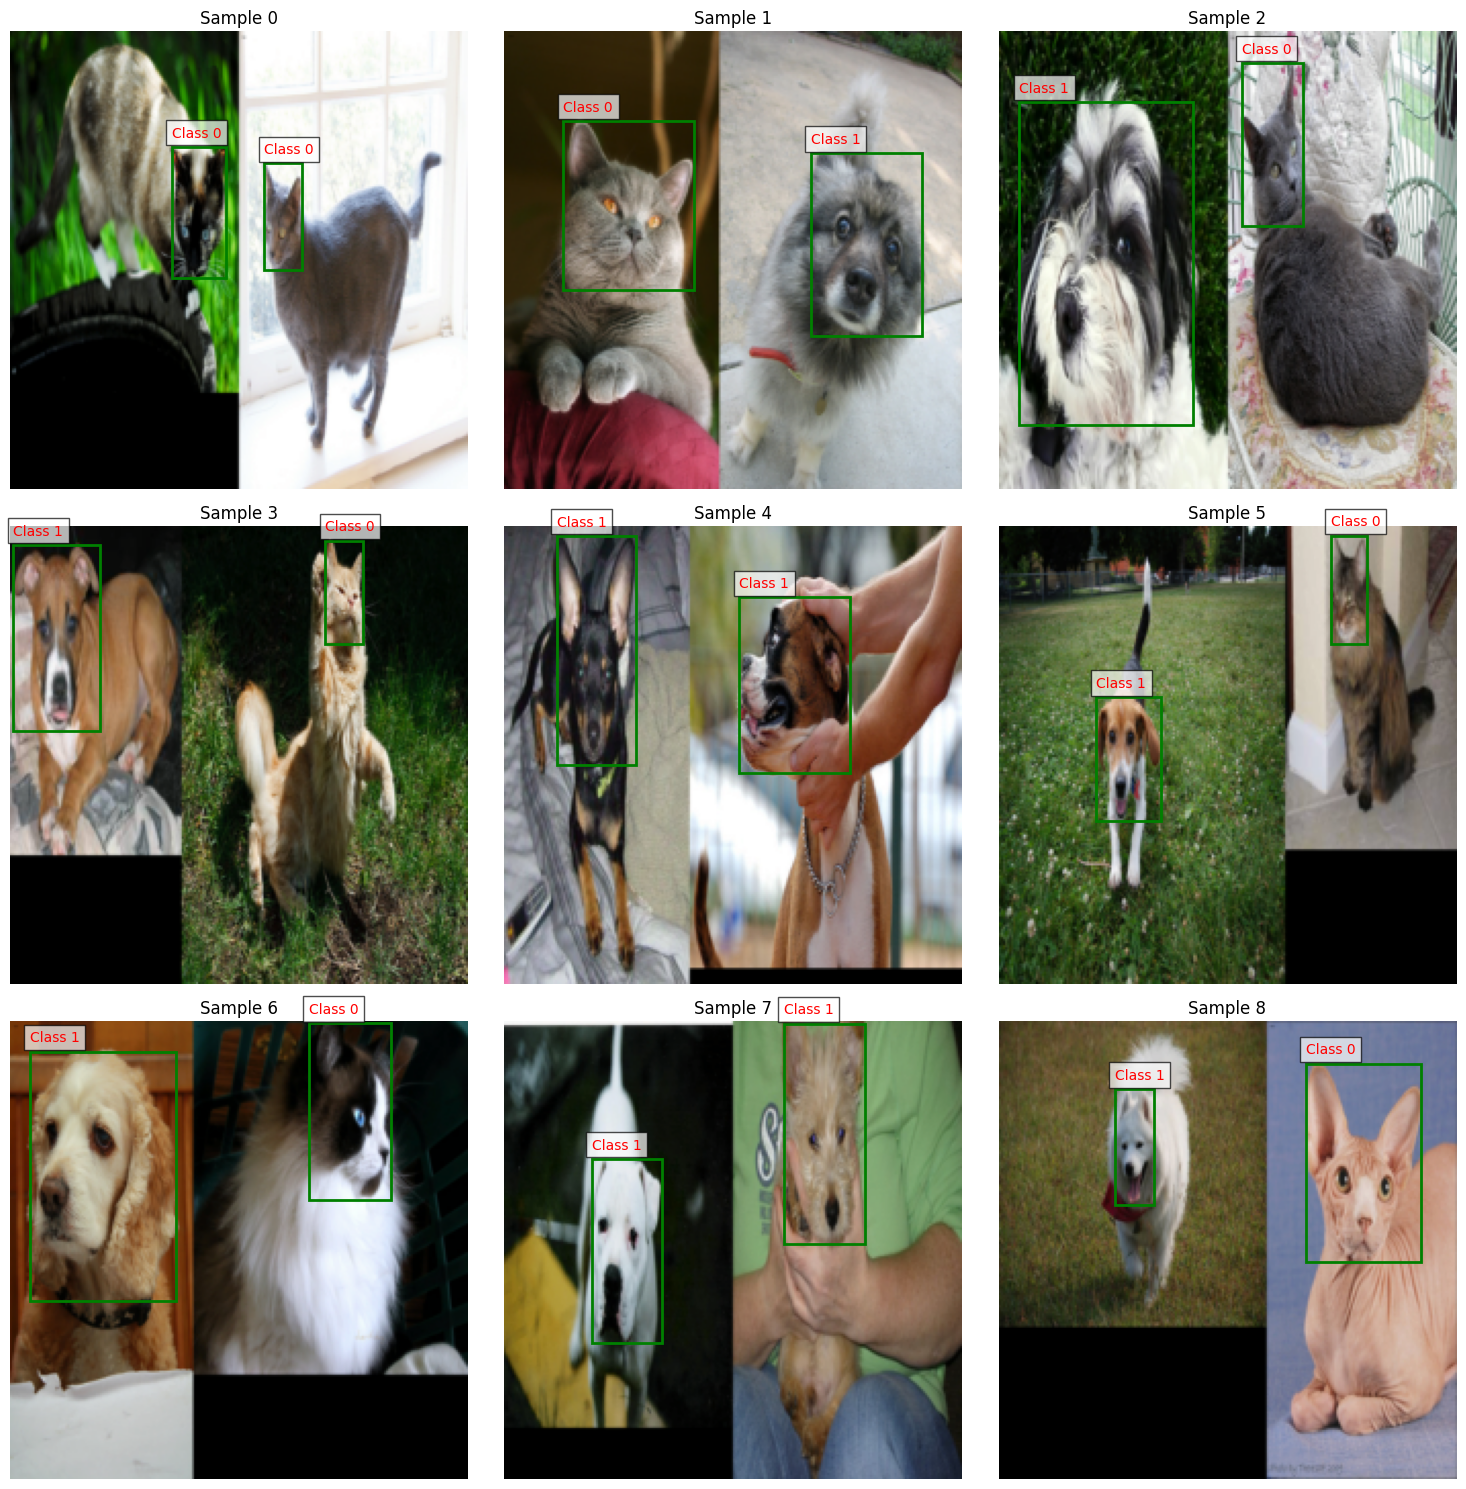

In [19]:
def visualize_data_samples(dataset, num_rows=3, num_cols=3, start_idx=0, class_to_idx=None):
    """
    Visualize samples from dataset with bounding boxes and labels
    
    Args:
        dataset: Dataset to visualize
        num_rows: Number of rows in grid
        num_cols: Number of columns in grid 
        start_idx: Starting index in dataset
        class_to_idx: Dictionary mapping class names to indices
    """
    # Add denormalization transform
    denorm = transforms.Compose([
        transforms.Normalize(
            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
            std=[1/0.229, 1/0.224, 1/0.225]
        )
    ])

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    axes = axes.flatten()

    for idx, ax in enumerate(axes):
        merged_image, annotations = dataset[start_idx + idx]

        # Denormalize the image before converting to PIL
        if isinstance(merged_image, torch.Tensor):
            merged_image = denorm(merged_image)
            # Clamp values to [0,1] range
            merged_image = torch.clamp(merged_image, 0, 1)
            image = transforms.ToPILImage()(merged_image)
        else:
            image = merged_image

        ax.imshow(image)

        # Draw each bounding box on the image
        for ann in annotations:
            bbox = ann[:4]
            label = int(ann[4].item())

            # Scale bounding box coordinates to image size
            width, height = image.size
            x_min = bbox[0] * width
            y_min = bbox[1] * height
            x_max = bbox[2] * width
            y_max = bbox[3] * height

            # Create a rectangle patch
            rect = patches.Rectangle(
                (x_min, y_min),
                x_max - x_min,
                y_max - y_min,
                linewidth=2,
                edgecolor="g",
                facecolor="none",
            )
            ax.add_patch(rect)

            # Add label text if class_to_idx is provided
            if class_to_idx:
                label_name = class_to_idx.get(label, f"Class {label}")
                ax.text(
                    x_min,
                    y_min - 5,
                    label_name,
                    color="r",
                    fontsize=10,
                    bbox=dict(facecolor="white", alpha=0.7),
                )

        ax.set_title(f"Sample {start_idx + idx}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Plot first grid (images 0-8)
visualize_data_samples(val_dataset, start_idx=0, class_to_idx=class_to_idx)


In [20]:
model = SimpleYOLO(num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-3)

# Train the model
num_epochs = 100
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, optimizer, num_epochs, device, num_classes
)


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1/100, Train Loss: 0.7757, Validation Loss: 0.7092, Validation mAP: 0.0056


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 2/100, Train Loss: 0.3701, Validation Loss: 0.4804, Validation mAP: 0.0123


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [1]:
def visualize_predictions(val_dataset, model, device, class_to_idx, num_rows=3, num_cols=3, start_idx=0):
    """
    Visualize model predictions vs ground truth on validation dataset
    
    Args:
        val_dataset: Validation dataset
        model: Trained model
        device: Device to run model on
        class_to_idx: Dictionary mapping class names to indices
        num_rows: Number of rows in grid
        num_cols: Number of columns in grid
        start_idx: Starting index in validation dataset
    """
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    axes = axes.flatten()

    for idx, ax in enumerate(axes):
        # Get image and annotations from validation dataset
        image_tensor, annotations = val_dataset[start_idx + idx]
        
        # Denormalize the image
        denorm = transforms.Compose([
            transforms.Normalize(
                mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                std=[1/0.229, 1/0.224, 1/0.225]
            )
        ])
        image_tensor = denorm(image_tensor)
        image_tensor = torch.clamp(image_tensor, 0, 1)
        
        # Convert tensor to PIL Image for display
        image = transforms.ToPILImage()(image_tensor)
        width, height = image.size

        # Get model predictions
        model.eval()
        with torch.no_grad():
            output = model(image_tensor.unsqueeze(0).to(device))
            output = output.view(1, 2, 2, 4 + len(class_to_idx))

        ax.axis("off")
        ax.imshow(image)

        # Draw ground truth boxes (in green)
        for ann in annotations:
            bbox = ann[:4]
            label = int(ann[4].item())
            name = list(class_to_idx.keys())[label]

            # Scale bounding box coordinates to image size
            xmin = bbox[0] * width
            ymin = bbox[1] * height
            xmax = bbox[2] * width
            ymax = bbox[3] * height

            # Draw ground truth box
            rect = patches.Rectangle(
                (xmin, ymin),
                xmax - xmin,
                ymax - ymin,
                linewidth=1,
                edgecolor="g",
                facecolor="none",
            )
            ax.add_patch(rect)
            ax.text(
                xmin,
                ymin - 10,  # Slightly above the box
                f"GT: {name}",
                color="white",
                fontsize=10,
                bbox=dict(facecolor="green", alpha=0.5),
            )

        # Draw predicted boxes (in red)
        for grid_y in range(2):
            for grid_x in range(2):
                class_pred = output[0, grid_y, grid_x, 4:].argmax().item()
                bbox = output[0, grid_y, grid_x, :4].tolist()

                if torch.all(torch.round(torch.tensor(bbox), decimals=1) == 0):
                    continue

                confidence = torch.softmax(output[0, grid_y, grid_x, 4:], dim=0)[
                    class_pred
                ].item()

                x_min = bbox[0] * width
                y_min = bbox[1] * height
                x_max = bbox[2] * width
                y_max = bbox[3] * height

                if confidence > 0.5:
                    rect = patches.Rectangle(
                        (x_min, y_min),
                        x_max - x_min,
                        y_max - y_min,
                        linewidth=1,
                        edgecolor="r",
                        facecolor="none",
                    )
                    ax.add_patch(rect)
                    ax.text(
                        x_min,
                        y_max + 10,  # Slightly below the box
                        f"Pred: {list(class_to_idx.keys())[class_pred]}: {confidence:.2f}",
                        color="white",
                        fontsize=10,
                        bbox=dict(facecolor="red", alpha=0.5),
                    )

    plt.tight_layout()
    plt.show()

# Plot first grid (images 0-8)
visualize_predictions(val_dataset, model, device, class_to_idx, start_idx=0)

# Plot second grid (images 9-17)
visualize_predictions(val_dataset, model, device, class_to_idx, start_idx=9)


NameError: name 'val_dataset' is not defined